<a href="https://colab.research.google.com/github/JonathanJuradoS/AprendizajeInstancias/blob/main/SOM_Satisfaccion_cliente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Instalar MiniSom
!pip install minisom


  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=6e58019ebc1ba0d692e4578d37f577b16697012d4e37a59ae5eda05a93370c8b
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom


In [2]:

import pandas as pd
import numpy as np
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:

# Cargar dataset
df = pd.read_csv("Espacio_Practico_knn.csv")
X = df[["Edad", "Frecuencia_Compras", "Monto_Promedio", "Tiempo_Cliente"]]
y = df["Satisfaccion"]


In [4]:

# Normalizar los datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [5]:

# Búsqueda de mejores parámetros
best_som = None
best_qe = float('inf')
best_params = {}

for x in [8, 10, 12]:
    for ymap in [8, 10, 12]:
        for sigma in [0.5, 1.0, 1.5]:
            som = MiniSom(x=x, y=ymap, input_len=X.shape[1], sigma=sigma, learning_rate=0.5)
            som.random_weights_init(X_scaled)
            som.train_random(X_scaled, 500)
            qe = som.quantization_error(X_scaled)
            if qe < best_qe:
                best_qe = qe
                best_som = som
                best_params = {'x': x, 'y': ymap, 'sigma': sigma}

print("Mejores parámetros encontrados:", best_params)


Mejores parámetros encontrados: {'x': 12, 'y': 12, 'sigma': 0.5}


In [6]:

# Asegurar que y es una Series válida
y = df["Satisfaccion"]

# Etiquetado por BMU
bmu_labels = {}
for i, x in enumerate(X_scaled):
    bmu = best_som.winner(x)
    if bmu not in bmu_labels:
        bmu_labels[bmu] = []
    bmu_labels[bmu].append(y.iloc[i])

# Determinar clase dominante por nodo
bmu_class = {bmu: max(set(labels), key=labels.count) for bmu, labels in bmu_labels.items()}

# Clasificación final
y_pred = []
for x in X_scaled:
    bmu = best_som.winner(x)
    y_pred.append(bmu_class.get(bmu, "Desconocido"))


              precision    recall  f1-score   support

        Alto       0.93      0.74      0.82      1074
        Bajo       0.85      0.90      0.87      1911
       Medio       0.78      0.82      0.80      2015

    accuracy                           0.83      5000
   macro avg       0.85      0.82      0.83      5000
weighted avg       0.84      0.83      0.83      5000



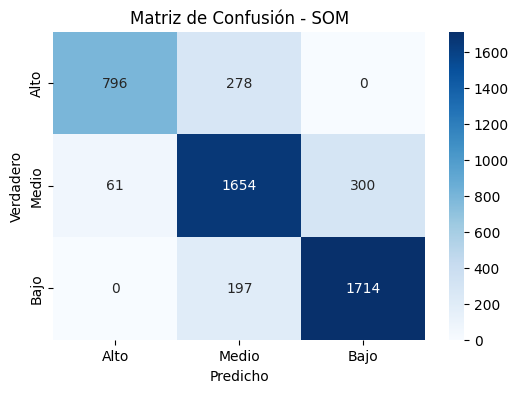

In [7]:

# Reporte de clasificación
print(classification_report(y, y_pred))

# Matriz de confusión
cm = confusion_matrix(y, y_pred, labels=["Alto", "Medio", "Bajo"])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Alto", "Medio", "Bajo"],
            yticklabels=["Alto", "Medio", "Bajo"])
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión - SOM")
plt.show()
